# Libraires

In [38]:
import json
with open('config.json') as f:
    config = json.load(f)
TOKENIZER_ID = config['TOKENIZER_ID']
nrows= config['nrows']

In [39]:
import pandas as pd
from sklearn.linear_model import PassiveAggressiveClassifier #used to train the model
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score, confusion_matrix, roc_auc_score, roc_curve # this is used to evaluate the model.
from sklearn.model_selection import train_test_split # to separate the dataset.

#to select the tokenizer
if TOKENIZER_ID == 'tfidf':
    from sklearn.feature_extraction.text import TfidfVectorizer
elif TOKENIZER_ID == 'bert':
    from transformers import BertTokenizer


import pickle as pkl #file to save and load a model.
from sklearn.model_selection import GridSearchCV #pour l'optimisation des hyperparametres.
import time #pour étudier le temps d'execution d'entrainement, de notre meilleure modèle.
import psutil #pour calculer la mémoire.
import os #pour calculer le temps d'execution.
import joblib
from sklearn.utils import shuffle
import seaborn as sns
import matplotlib.pyplot as plt

# Load Data

In [40]:
import pandas as pd
from sklearn.utils import shuffle

data = pd.read_csv('title_text.csv', nrows=None).drop(['Unnamed: 0'], axis=1)
data.head()

,title,text,isFake
0,House Majority Leader REVELATION: ‘I Think Pu...,House Majority Leader Kevin McCarthy one of ...,True
1,WATCH: ’’Carpetbagger” Mitt Romney Takes Swipe...,The GOP presidential candidate who couldn t se...,True
2,REMEMBER WHEN Democrat Operatives Were Caught ...,Watch:. @Jordanfabian If there is no #VoterFra...,True
3,U.S. judge throws out Texas voter ID law suppo...,(Reuters) - A federal court judge on Wednesday...,False
4,FEEL THE BERN….How Hillary Walked Away From NH...,"First she won the coin toss in Iowa, and now H...",True


In [41]:
data['isFake'].unique()

array([ True, False])

In [42]:
data.shape

(42834, 3)

In [43]:
#we make everything lower.
data['text']=data['text'].apply(lambda x: x.lower())
data

,title,text,isFake
0,House Majority Leader REVELATION: ‘I Think Pu...,house majority leader kevin mccarthy one of ...,True
1,WATCH: ’’Carpetbagger” Mitt Romney Takes Swipe...,the gop presidential candidate who couldn t se...,True
2,REMEMBER WHEN Democrat Operatives Were Caught ...,watch:. @jordanfabian if there is no #voterfra...,True
3,U.S. judge throws out Texas voter ID law suppo...,(reuters) - a federal court judge on wednesday...,False
4,FEEL THE BERN….How Hillary Walked Away From NH...,"first she won the coin toss in iowa, and now h...",True
...,...,...,...
42829,STUPID Trump Fans Think He Won The Popular Vo...,as we unfortunately learned during the preside...,True
42830,BOTTOM FEEDERS PAINT “TEAR IT DOWN” on New Orl...,here we go yet another statue of a military he...,True
42831,Europe could be next mission for Merkel's 'Mr ...,berlin (reuters) - peter altmaier once said he...,False
42832,FBI: Clinton Foundation investigation will lea...,21st century wire says yesterday we learned th...,True


# Modification du text en données numériques.
Nous partons du principe que les données ont étés clean et que nous pouvons nous concerntrer à créer un model.

Comme les informations principales pour définir des Fake news et des vrai news, se base sur le texte et le titre, nous devons nous focaliser sur ces informations. Il faut ainsi que nous transformons le text et le titre en données afin que notre model puisse utiliser des données numériques pour trouver la bonne réponse. Nous allons utiliser la methode de TF-IDF vectorizing.

### TF-IDF vectorizer
Cette méthode offre la possibilité de déterminer les scores TF-IDF de nos données textuelles. Ce qui signifie : 

TF -> la Fréquence du Terme : le nombre de fois qu'un mot apparaît, en éliminant les mots qui ne sont pas importants.

IDF -> la fréquence inverse de détection : le même concept que TF, mais l'analyse va au-delà de la simple ligne, la fréquence dans l'ensemble du dataset est analysée.

Ces informations seront utilisées comme données pour notre modèle d'apprentissage automatique.

(il est important de faire cela uniquement sur nos données d'entraînement, sinon le modèle connaîtra les données de test)

In [55]:
if TOKENIZER_ID == 'tfidf':
    tfidf_filename='tfidf_vectorizer.pkl'
    X=data.drop(['isFake'],axis=1)
    y=data['isFake']
    #spearation en données d'entrainement et de test.
    X_train, X_test, y_train, y_test = train_test_split(X['text'], y, test_size=0.2, random_state=42)

    tfidf_vectorizer=TfidfVectorizer(use_idf=True)

    # On fit et transforme les données d'entrainement.
    tfidf_train=tfidf_vectorizer.fit_transform(X_train).toarray()

    # on transfomer uniquement le test set, sinon il va connaitre les données test...
    tfidf_test=tfidf_vectorizer.transform(X_test)

    joblib.dump(tfidf_vectorizer, tfidf_filename) #on stoque le vectorizer dans un fichier pour le reutiliser plus tard.
    
elif TOKENIZER_ID=='bert':
    tfidf_filename='bert_tokenizer.pkl'
    from transformers import BertTokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
    X=data.drop(['isFake'],axis=1)
    y=data['isFake']
    #we need to tokenize X
    X_tokenized = X.apply(lambda x: tokenizer.tokenize(x))
    #spearation en données d'entrainement et de test.
    X_train, X_test, y_train, y_test = train_test_split(X_tokenized, y, test_size=0.2, random_state=42)

    joblib.dump(tokenizer, tfidf_filename)

TypeError: expected string or bytes-like object, got 'Series'

In [47]:
X_train.shape

(34267,)

In [49]:
X_test.shape,y_test.shape

((8567,), (8567,))

# Model Passive Agressive

Quand on parle d'un model passive aggressive, nous parlons d'un algorithme linéaire de classification et de regression. C'est un algorithme d'apprentissage en ligne, Il traite les données séquentiellement, ajustant le prédicteur à chaque nouvelle instance pour améliorer la prédiction future.

Le modèle se base sur deux principes:
- **Passive**: Si notre modèle prédit une instance juste, alors les poids et les biais ne seront pas changés. L'état actuelle de notre modèle sera maintenu.
- **Aggressive**: Si notre modèle fait une mauvaise prédiction sur une instance ressus, les poids et biais de notre modèle seront changés par le paramètre de régularisation **C**, le but étant de minimiser l'erreur. Il change les paramètres pour que la prédiction actuelle soit 'just'.

Le modèle utilise par défaut la fonction de cout **hinge**. Voici comment mathématiquement les poids et bias seront changés:

$$ w_{\text{new}} = w + \alpha y x $$
$$ b_{\text{new}} = b + \alpha y $$

où **w** est le vecteur de poids, **b** est le biais, **x** est le vecteur de caractéristiques de l'instance mal classée, **y** est l'étiquette correcte de l'instance, et **α** est le taux d'apprentissage calculé en fonction de l'erreur et du paramètre de régularisation **C**

Comme nous traitons des données de texte, et que nous devons faire une classification binaire, il ce va de dire que les text vont avoir des pattern differents, en utilisant le model passive aggressive, nous pouvons entrainer le model à définir une méthode pour les idenfifier.

In [50]:
# we build our model: C is the regulation parameter, and denotes the penalization the model will make on an incorrect prediciton.
model = PassiveAggressiveClassifier(C = 0.2, 
                                    random_state = 42,
                                    early_stopping=True,# we enable the early stopping procedure.
                                    n_iter_no_change=3, #number of iterations before early stopping
                                    verbose=True,
                                    loss='hinge', #fonction de cout
                                   )


In [51]:
filenm = 'PassiveAggressiveClassifier_model.pickle'

In [54]:
#on entraine le model sur les données d'entrainement.
model.fit(X_train,y_train)
#Create or open a file with write-binary mode and save the model to it
pickle = pkl.dump(model, open(filenm, 'wb'))

ValueError: could not convert string to float: 'the video begins with a clearly agitated pro-illegal alien female approaching trump supporters. after a few of the agitators who were part of her group began to act in a hostile and threatening manner, police officers stepped in to form a barrier between the groups. the human barrier they formed was clearly not okay with the agitators who were looking to use physical force to shut up and shut down their opponents. shortly after the police officer explained that the trump supporters had a permit (which means nothing to people who have no regard for the law and are actually protesting on behalf of lawbreakers), another man who appears to be hispanic, wearing a hoodie began to aggressively approach the crowd. we re not sure if these people were being paid to threaten the pro-trump supporters or if they just happened to be angry supporters of illegal aliens, and were in the area.the hispanic man on the pro-trump side in the background, who was holding a  deport illegals  sign can be heard telling the pro-illegal agitators that he s  a legal american citizen  and he stands by president trump. he hilariously follows up his comment with,  homies for trump.  the same man can be seen last night at a pro-trump rally on hollywood blvd. prior to the oscar award ceremony in the video below where things did actually get violent and one obnoxious anti-trump agitator got a surprise right hook from a pro-trump woman after she was assaulted.watch:watch the video of the chaos that took place last night on hollywood blvd in los angeles just prior to the oscar award ceremony. the legal hispanic american seen in the video above is also present at this rally:'

In [87]:
#on sort les predictions
#Step 2: Open the saved file with read-binary mode
model = pkl.load(open(filenm, 'rb'))
y_pred=model.predict(tfidf_test)

# Optimisation

Pour optimiser le model nous allons modifier les paramètres suivants:
- **C (Le paramètre de régularisation)**: Un des paramètres les plus importants de l'algorithme passive aggressive. Il est utilisé pour controler la marge d'erreur que notre modèle est près à accepté. Si on lui donne une valeur de plus en plus élevé il se peut que le modèle suraprenne, car il s'adapte mieux aux données d'entrainement. Ainsi une valeur plus faible serait favorable. Nous allons tester C avec les valeurs suivantes: **[0.01,0.05,0.1,0.5,1]**

In [89]:
# Import necessary modules
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import make_scorer, accuracy_score

# Define the grid of hyperparameters to search
params_grid={'C':[0.01,0.05,0.1,0.5,1]}

# Initialize the Passive Aggressive Classifier
model = PassiveAggressiveClassifier(random_state=42, early_stopping=True)
# - random_state: Controls the random seed used for shuffling the data.
# - early_stopping: Whether to use early stopping to terminate training when validation score is not improving.

# Create a scorer for the grid search
scorer = make_scorer(accuracy_score)
# - make_scorer: Make a scorer from a performance metric or loss function.

# Initialize the GridSearch to find the best parameter
grid_search = GridSearchCV(estimator=model, 
                           param_grid=params_grid, 
                           scoring=scorer, 
                           cv=KFold(n_splits=5))
# - estimator: The estimator object.
# - param_grid: Dictionary with parameters names (string) as keys and lists of parameter settings to try as values.
# - scoring: Scorer object or callable.
# - cv: Determines the cross-validation splitting strategy.

# Fit the grid search to the training data
grid_search.fit(tfidf_train, y_train)


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=PassiveAggressiveClassifier(early_stopping=True,
                                                   random_state=42),
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1]},
             scoring=make_scorer(accuracy_score, response_method='predict'))

In [90]:
# Get the best combination of parameters
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")

Best parameters: {'C': 0.5}
Best score: 0.9149999999999998


# Model Evaluation

Afin d'évaluer le modèle nous faisons une représentation graphique des résultats obtenus. Nous allons étudier les metrics suivants:
- le **temps d'entrainement** que le modèle a besoin, ainsi que son **taux de mémoire (Mo)**.
- **matrice de confusion**, qui est un excellent choix d'évaluation de performance, car nous sommes dans le cas d'une classification binaire. 
- **L'accuracy** du model.
- **La précision**
- **recall**
- **F1-score**.
- **ROC-AUC score**

src: https://www.v7labs.com/blog/performance-metrics-in-machine-learning#h2

In [91]:
#creation du modèle avec les meilleurs paramètres
best_model=PassiveAggressiveClassifier(C=best_params['C'],
                                       early_stopping=True,
                                       verbose=True,
                                       random_state=42)

Nous voullons étudier **le temps d'entrainement (en h/m/s)** et **l'utilisation de la mémoire (Mo)** que le modèle a besoin.

In [92]:
def second_to_hms(seconds):
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    seconds = seconds % 60
    return int(hours), int(minutes), int(seconds)

def bytes_to_Mo(mem_bytes):
    mem_kb = mem_bytes / 1024  # Convertir en kilooctets
    mem_mb = mem_kb / 1024  # Convertir en mégaoctets
    return mem_mb

In [93]:
#lancemenet de l'enrestristrement de la mémoire.
process = psutil.Process(os.getpid())
mem_before_bytes = process.memory_info().rss

#lancement de l'enregistrement du temps d'entrainement.
start_time = time.time() 
# entrainement du modèle.
best_model.fit(tfidf_train,y_train)
end_time = time.time()

#le temps écoulé 
elapsed_time= end_time - start_time

print(f"Temps d'entrainement (h | m | s) : {second_to_hms(elapsed_time)[0]} | {second_to_hms(elapsed_time)[1]} | {second_to_hms(elapsed_time)[2]}")

mem_after_bytes = process.memory_info().rss
#on convertit les bytes en Mo.
mem_bytes=mem_after_bytes - mem_before_bytes


print(f"Utilisation de la mémoire (Mo) : {bytes_to_Mo(mem_bytes)}")

-- Epoch 1
Norm: 6.77, NNZs: 9329, Bias: -0.400056, T: 178, Avg. loss: 0.877431
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 10.97, NNZs: 9833, Bias: -0.518015, T: 356, Avg. loss: 0.424625
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 12.75, NNZs: 9970, Bias: 0.461481, T: 534, Avg. loss: 0.164534
Total training time: 0.02 seconds.
-- Epoch 4
Norm: 13.46, NNZs: 9970, Bias: 0.078867, T: 712, Avg. loss: 0.070900
Total training time: 0.03 seconds.
-- Epoch 5
Norm: 13.85, NNZs: 9970, Bias: -0.166784, T: 890, Avg. loss: 0.041139
Total training time: 0.03 seconds.
-- Epoch 6
Norm: 13.95, NNZs: 9970, Bias: -0.104844, T: 1068, Avg. loss: 0.019025
Total training time: 0.04 seconds.
-- Epoch 7
Norm: 13.99, NNZs: 9970, Bias: -0.051266, T: 1246, Avg. loss: 0.014855
Total training time: 0.04 seconds.
-- Epoch 8
Norm: 14.01, NNZs: 9970, Bias: 0.013849, T: 1424, Avg. loss: 0.012997
Total training time: 0.05 seconds.
-- Epoch 9
Norm: 14.02, NNZs: 9970, Bias: -0.012049, T: 1602, Avg. loss: 

In [94]:
#Create or open a file with write-binary mode and save the model to it
pickle = pkl.dump(best_model, open(filenm, 'wb'))

In [95]:
#optention des prédictions de ce modèle.
y_pred=best_model.predict(tfidf_test)

Nous déterminons la **matrice de confusion**.

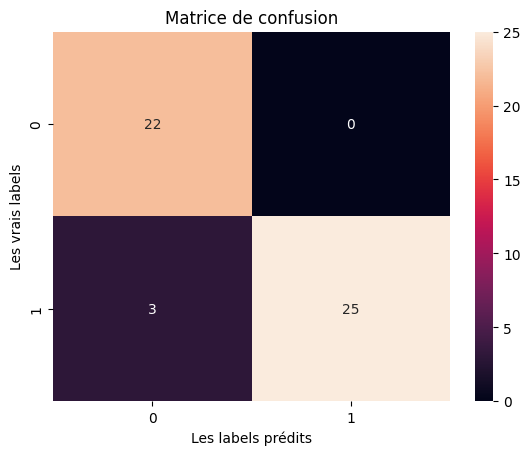

In [96]:
#creation de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

#représentation graphique du résultat du meilleure model
sns.heatmap(cm, annot=True)
plt.xlabel('Les labels prédits')
plt.ylabel('Les vrais labels')
plt.title('Matrice de confusion')
plt.show()

In [97]:
print(f"le modèle a donc {cm[0][0]} instances vrai Positives et {cm[1][1]} instances de Vrai négatives, {cm[1][0]} instances de Faux Positives et {cm[0][1]} instances de Faux négatives. ")

le modèle a donc 22 instances vrai Positives et 25 instances de Vrai négatives, 3 instances de Faux Positives et 0 instances de Faux négatives. 


Nous allons avant tout calculer **la précision globale (accuracy)** de notre modèle. 

In [98]:
acc=accuracy_score(y_pred,y_test)
print(f"Notre modèle a une précision globale de {round(acc*100,2)}%, ce qui signifie qu'il prédit correctement les classes des instances dans {round(acc*100,2)}% des cas.")

Notre modèle a une précision globale de 94.0%, ce qui signifie qu'il prédit correctement les classes des instances dans 94.0% des cas.


on calcul le **precision**, c'est la capacité du modèle à correctement identifier les instances que nous avons prédits. Donc de prédire qu'une News vrai soit vraie.

In [99]:
precision=precision_score(y_test,y_pred)
print(f"notre model a une precision de {round(precision*100,2)}% . lorsqu'il prédit une classe comme positive, il a raison dans {round(precision*100,2)}% des cas.")

notre model a une precision de 100.0% . lorsqu'il prédit une classe comme positive, il a raison dans 100.0% des cas.


on calcul le **recall**, ce qui es le pourcentage de Vrai positif **(dans notre cas les Vrai news)** que notre modèle arrive à prédire.

In [100]:
recall=recall_score(y_test,y_pred)
print(f"notre model arrive a détecter {round(recall*100,2)}%. Donc sur l'ensemble des vrai positives, le modèle parvient à en identifier correctement {round(recall*100,2)}% des cas.")

notre model arrive a détecter 89.29%. Donc sur l'ensemble des vrai positives, le modèle parvient à en identifier correctement 89.29% des cas.


On calcule le **F1-score**, c'est une combinaison de la précision et du recall, en calculant la moyenne harmonique entre les deux. Son but est **d'étudier l'équilibre entre la precision et le recall.**

In [101]:
f1score=f1_score(y_test,y_pred)
print(f"notre model a un F1-score de {round(f1score*100,2)}%, ce qui signifie que il y a un excellent equilibre entre le recall et la précision.")

notre model a un F1-score de 94.34%, ce qui signifie que il y a un excellent equilibre entre le recall et la précision.


## Courbe ROC-AUC
Dans le contexte d'une classification binaire, il est essentiel d'utiliser la courbe ROC-AUC pour évaluer notre modèle. Nous allons examiner deux aspects :

- **ROC (Receiver Operating Characteristic)**: Cette courbe illustre le rapport entre le taux de vrais positifs et le taux de faux positifs. Elle permet de visualiser la capacité du modèle à discriminer entre les deux classes.

- **AUC (Area Under the Curve)**: C'est une mesure qui résume la courbe ROC en calculant l'aire sous celle-ci et au-dessus de la diagonale qui va du coin inférieur gauche au coin supérieur droit du graphique. Un score AUC proche de 1 indique que notre modèle fait des prédictions presque parfaites. En revanche, un score proche de 0,5 suggère que nos prédictions sont principalement due au hasard, ce qui signifie que le modèle n'apprend pas de manière efficace.

L'objectif de ces mesures est de déterminer à quel point notre modèle est efficace dans la tâche de classification binaire.

On définit le score ROC-AUC.

In [102]:
roc_auc=roc_auc_score(y_test,y_pred)
roc_auc

0.9464285714285714

In [103]:
print(f"Le modèle a donc une score ROC-AUC de {roc_auc} ce qui est très proche de 1, donc le modèle a une excellente capacité à différencier entres les Fake et les vrais news.")

Le modèle a donc une score ROC-AUC de 0.9464285714285714 ce qui est très proche de 1, donc le modèle a une excellente capacité à différencier entres les Fake et les vrais news.


Avec une valeur aussi élevée, nous pouvons être confiants dans le fait que notre modèle est extrêmement précis et fiable pour notre tâche de classification, avec très peu de faux positifs et de faux négatifs. Cela indique que notre modèle fait des erreurs de prédiction minimales. Nous allons maintenant procéder à la représentation graphique de la courbe ROC-AUC.

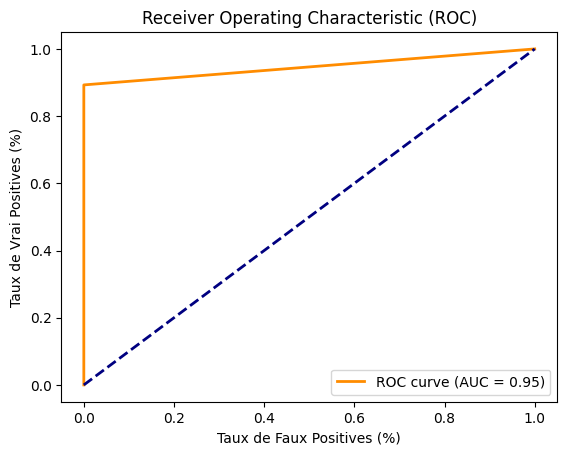

In [104]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taux de Faux Positives (%)')
plt.ylabel('Taux de Vrai Positives (%)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

L'axe des abscisses (axe x) représente le taux de faux positifs, c'est-à-dire le pourcentage de vraies nouvelles que notre modèle a incorrectement classifiées comme fausses (Fake News).

L'axe des ordonnées (axe y) indique le taux de vrais positifs, qui correspond au pourcentage de fausses nouvelles que notre modèle a correctement identifiées comme telles.

La courbe montante vers le coin supérieur gauche du graphique suggère que le modèle parvient à maintenir un taux élevé de vrais positifs tout en minimisant le taux de faux positifs, ce qui est le comportement idéal pour un classificateur. 
Cette représentation représente la robustesse du mdoèle.

# Test de performances sur des données générées par Téléchargé ailleurs

In [105]:
filenm = 'PassiveAggressiveClassifier_model.pickle'
tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')
best_model=pkl.load(open(filenm, 'rb'))

In [106]:
validation_data=pd.read_csv("data/validation_data.csv")
validation_data.head()

,Unnamed: 0,text,isFake
0,0,"Daniel Greenfield, a Shillman Journalism Fello...",False
1,1,Google Pinterest Digg Linkedin Reddit Stumbleu...,False
2,2,U.S. Secretary of State John F. Kerry said Mon...,True
3,3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",False
4,4,It's primary day in New York and front-runners...,True


In [107]:
validation_data=validation_data[['text','isFake']]
validation_data

,text,isFake
0,"Daniel Greenfield, a Shillman Journalism Fello...",False
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,False
2,U.S. Secretary of State John F. Kerry said Mon...,True
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",False
4,It's primary day in New York and front-runners...,True
...,...,...
6330,The State Department told the Republican Natio...,True
6331,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,False
6332,Anti-Trump Protesters Are Tools of the Oligar...,False
6333,"ADDIS ABABA, Ethiopia —President Obama convene...",True


In [108]:
# Prepare the data
validation_data_X = validation_data['text'].apply(lambda x: x.lower())  # the text data
validation_data_y=validation_data['isFake']

# Transform the data using the TF-IDF Vectorizer
X_tfidf = tfidf_vectorizer.transform(validation_data_X)

# Use the trained model to make predictions on the dataset
predictions = best_model.predict(X_tfidf)

In [109]:
confusion_matrix(validation_data_y,predictions)

array([[ 452, 2712],
       [1150, 2021]], dtype=int64)

In [110]:
accuracy_score(validation_data_y,predictions)

0.390370955011839

# Conclusion

les évaluations et analyses approfondies de notre modèle confirment qu'il est extrêmement efficace et fiable pour l'identification des fake news. Ses performances élevées sur plusieurs métriques clés (accuracy,precision,recall,F1-score et ROC-AUC) démontrent sa capacité à fournir des prédictions précises et équilibrées, confortant notre choix d'utiliser ce modèle pour cette tache.